In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean= (0.5),std = (0.5))])

In [3]:
train_dataset = torchvision.datasets.MNIST(root=".",train = True,transform=transform,download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 123339685.61it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105887844.25it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38706325.40it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19146260.07it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
len(train_dataset)

60000

In [5]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

In [6]:
#Discriminator

D = nn.Sequential(nn.Linear(784,512),
                  nn.LeakyReLU(0.2),
                  nn.Linear(512,256),
                  nn.LeakyReLU(0.2),
                  nn.Linear(256,1))



In [7]:

# from torch.nn.modules.batchnorm import BatchNorm1d
# from torch.nn.modules.activation import LeakyReLU
#Generator

latent_dim = 100
G = nn.Sequential(nn.Linear(latent_dim,256),
                  nn.LeakyReLU(0.2),
                  nn.BatchNorm1d(256,momentum=0.7),
                  nn.Linear(256,512),
                  nn.LeakyReLU(0.2),
                  nn.BatchNorm1d(512,momentum=0.7),
                  nn.Linear(512,1024),
                  nn.LeakyReLU(0.2),
                  nn.BatchNorm1d(1024,momentum=0.7),
                  nn.Linear(1024,784),
                  nn.Tanh()

)



In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
G.to(device)
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)

In [10]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002, betas=(0.5, 0.999))

In [11]:
#scale image
def scale_image(img):
  out = (img + 1)/2
  return out

In [12]:
#folder to store generate images

if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [26]:
#training

d_losses = []
g_losses = []

n_ones = torch.ones(batch_size,1).to(device)
n_zeros = torch.zeros(batch_size,1).to(device)
epochs = 200
for i in range(epochs):

  for inputs, _ in data_loader:

    inputs = inputs.to(device)


    #Discriminator training

    n = inputs.size(0)
    inputs = inputs.reshape(n,784)

    ones = n_ones[:n]
    zeros = n_zeros[:n]

    #real images



    outputs_real = D(inputs)

    loss_d_real = criterion(outputs_real,ones)

    #Fake images

    noise = torch.randn(n,latent_dim).to(device)
    inputs_fake = G(noise)
    outputs_fake = D(inputs_fake)

    loss_d_fake = criterion(outputs_fake,zeros)

    loss_d = (loss_d_real + loss_d_fake) * 0.5
    d_optimizer.zero_grad()


    loss_d.backward()

    d_optimizer.step()


    #Generator training

    for _ in range(2):



      noise = torch.randn(n,latent_dim).to(device)
      inputs_fake = G(noise)
      outputs_fake = D(inputs_fake)

      loss_g = criterion(outputs_fake,ones)

      g_optimizer.zero_grad()

      loss_g.backward()

      g_optimizer.step()


    g_losses.append(loss_g.item())
    d_losses.append(loss_d.item())

  print(f"epoch-- {i+1}   d_loss-- {loss_d.item()}   g_loss-- {loss_g.item()}")

  fake_images = inputs_fake.reshape(-1,1,28,28)

  save_image(scale_image(fake_images),f"gan_images/{i+1}.png")


epoch-- 1   d_loss-- 0.6933844089508057   g_loss-- 0.6851305365562439
epoch-- 2   d_loss-- 0.6910004615783691   g_loss-- 0.6052621603012085
epoch-- 3   d_loss-- 0.7046351432800293   g_loss-- 0.6284312605857849
epoch-- 4   d_loss-- 0.6925321221351624   g_loss-- 0.7144312262535095
epoch-- 5   d_loss-- 0.6856196522712708   g_loss-- 0.720903754234314
epoch-- 6   d_loss-- 0.6884466409683228   g_loss-- 0.7409433126449585
epoch-- 7   d_loss-- 0.691750168800354   g_loss-- 0.7061120271682739
epoch-- 8   d_loss-- 0.6893000602722168   g_loss-- 0.7513664960861206
epoch-- 9   d_loss-- 0.6982811689376831   g_loss-- 0.7181024551391602
epoch-- 10   d_loss-- 0.6977366805076599   g_loss-- 0.7040532827377319
epoch-- 11   d_loss-- 0.6892119646072388   g_loss-- 0.7001773715019226
epoch-- 12   d_loss-- 0.6842108964920044   g_loss-- 0.7150954604148865
epoch-- 13   d_loss-- 0.6819648146629333   g_loss-- 0.7193644046783447
epoch-- 14   d_loss-- 0.6829686760902405   g_loss-- 0.7093290090560913
epoch-- 15   d_lo

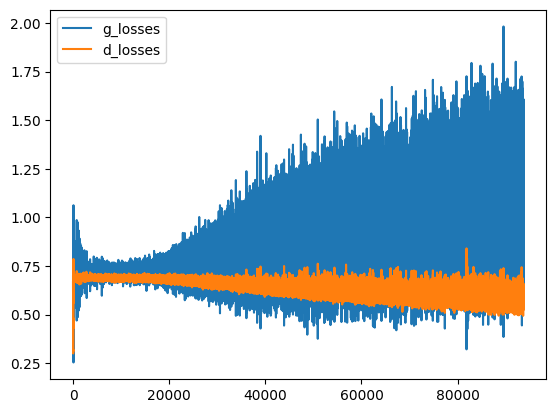

In [27]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

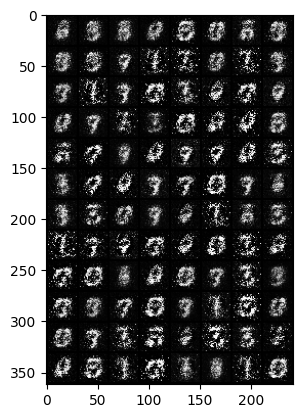

In [31]:
from skimage.io import imread
img = imread("gan_images/1.png")
plt.imshow(img)
plt.show()

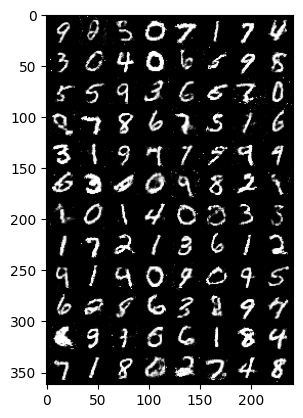

In [32]:
img = imread("gan_images/50.png")
plt.imshow(img)
plt.show()

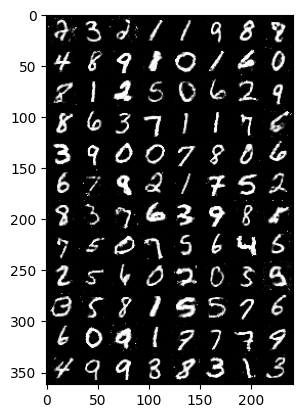

In [33]:
img = imread("gan_images/100.png")
plt.imshow(img)
plt.show()

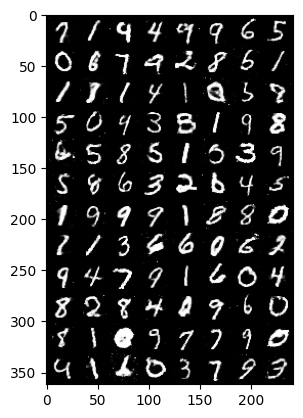

In [34]:
img = imread("gan_images/150.png")
plt.imshow(img)
plt.show()

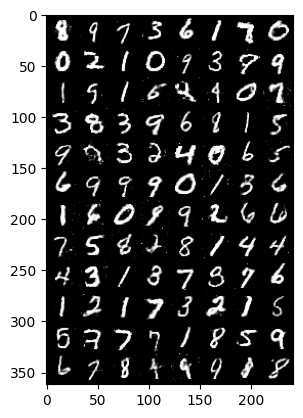

In [35]:
img = imread("gan_images/200.png")
plt.imshow(img)
plt.show()